#**Problema**

A empresa de telecomunicações contratou a A3Data para avaliar o cenário de
churn elevado dos seus clientes e, uma vez que estamos falando de um produto
com custo elevado de setup (instalação), a empresa gostaria de uma estratégia
para reduzir esse churn.

#**Passo 1: Explorar os dados**


---



Primeiramente vamos ver com que dados estamos lidando, quais os tipos das colunas e que informações temos no dataset

In [51]:
#Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

#Importar os dados
df = pd.read_csv('/content/drive/MyDrive/Customer-Churn - Customer-Churn.csv')

#visualizar as primeiras linhas
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

O dataset tem 21 colunas e quase todas estão completas com exceção da TotalCharges que possui 11 dados faltantes e essa quantidade não é relevante para o número de dados

In [53]:
# Remover a coluna customerID
df.drop(columns=['customerID'], inplace=True)

# Tratar dados faltantes na coluna TotalCharges
# Converter TotalCharges para numérico, forçando erros a NaN e, em seguida, preenchendo NaN com a média da coluna
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

#**Testando Hipótese 1**

Meu primeiro passo será verificar o percentual de churn dessa base de clientes, para isso vou usar a coluna "Churn". Minha hipotese é que tenhamos um percentual alto de churn

In [54]:
total_customers = df.shape[0]
print(f'Total de clientes: {total_customers}')

churn_customers = df[df['Churn'] == 'Yes'].shape[0]
print(f'Clientes com Churn: {churn_customers}')

churn_percentage = (churn_customers / total_customers) * 100
print(f'Percentual de Churn: {churn_percentage:.2f}%')

Total de clientes: 7043
Clientes com Churn: 1869
Percentual de Churn: 26.54%


Tivemos 1869 clientes com churn o que representa 26,54% da base analisada. É um número considerável de clientes e precisamos analisar o que tem levado a esses cancelamentos de serviço.

#**Testando Hipótese 2**


---



Agora quero descobrir o perfil de quem está cancelando o serviço.

##**Qual o gênero das pessoas**

In [55]:
#Contagem de valores na coluna gênero
print(df['gender'].value_counts())
print('---------'*20)

#Visualizar quantas pessoas em cada gênero cancelaram o serviço
churn_gender = df.groupby('gender')['Churn'].value_counts()
print(churn_gender)

gender
Male      3555
Female    3488
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gender  Churn
Female  No       2549
        Yes       939
Male    No       2625
        Yes       930
Name: count, dtype: int64


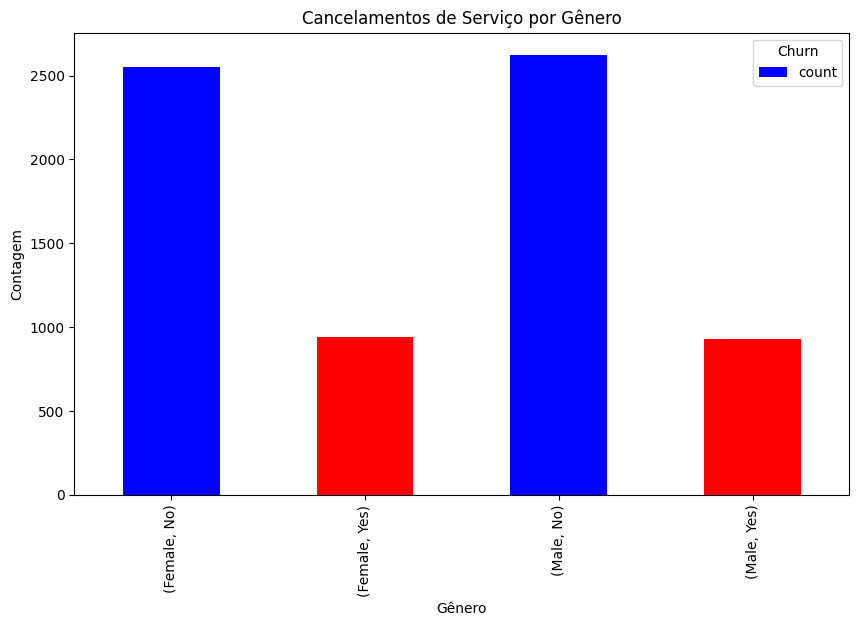

In [56]:
# Criar um gráfico de barras para visualizar os dados
churn_gender.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))

# Adicionar títulos e rótulos aos eixos
plt.title('Cancelamentos de Serviço por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Churn')
plt.show()

O conjunto está equilibrado em relação ao gênero das pessoas e de acordo com os números o gênero não afeta significativamente o cancelamento de serviço

##Pessoas idosas

In [57]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

Essa variável presenta se a pessoa é idosa (1) ou não (0), podemos testar se isso tem relação com os cancelamentos

In [58]:
# Analisar churn por idade
idoso = df[df['SeniorCitizen'] == 1]
print('Idosos:')
idoso_churn_counts = idoso['Churn'].value_counts()
total_idoso = idoso_churn_counts.sum()
idoso_percentual_churn = ((idoso_churn_counts / total_idoso) * 100).round(2)
print(idoso_churn_counts)
print(f'Percentual de churn em idosos:\n{idoso_percentual_churn}\n')
print('------'*20)
nao_idoso = df[df['SeniorCitizen'] == 0]
print('Não idosos:')
nao_idoso_churn_counts = nao_idoso['Churn'].value_counts()
total_nao_idoso = nao_idoso_churn_counts.sum()
nao_idoso_percentual_churn = ((nao_idoso_churn_counts / total_nao_idoso) * 100).round(2)
print(nao_idoso_churn_counts)
print(f'Percentual de churn em não idosos:\n{nao_idoso_percentual_churn}\n')

Idosos:
Churn
No     666
Yes    476
Name: count, dtype: int64
Percentual de churn em idosos:
Churn
No     58.32
Yes    41.68
Name: count, dtype: float64

------------------------------------------------------------------------------------------------------------------------
Não idosos:
Churn
No     4508
Yes    1393
Name: count, dtype: int64
Percentual de churn em não idosos:
Churn
No     76.39
Yes    23.61
Name: count, dtype: float64



A idade influencia no cancelamento sendo que entre os idosos 41,68% dos clientes cancelaram já entre os não idosos o cancelamento foi de 23,6%

##Cancelamentos e Existência de dependentes

Para continuar estudando o perfil dos cancelamentos vou verificar se quem cancelou possui dependentes ou não.

Explicação: podemos pensar por dois lados, a presença de dependentes aponta para maiores gastos familiares, por outro lado, os dependentes podem impulsionar o uso dos serviços como streaming de TV e de filmes

In [59]:
#Cruzar a informação de cancelamentos e a existência de dependentes
churn_dependents = df.groupby('Dependents')['Churn'].value_counts()
print(churn_dependents)

Dependents  Churn
No          No       3390
            Yes      1543
Yes         No       1784
            Yes       326
Name: count, dtype: int64


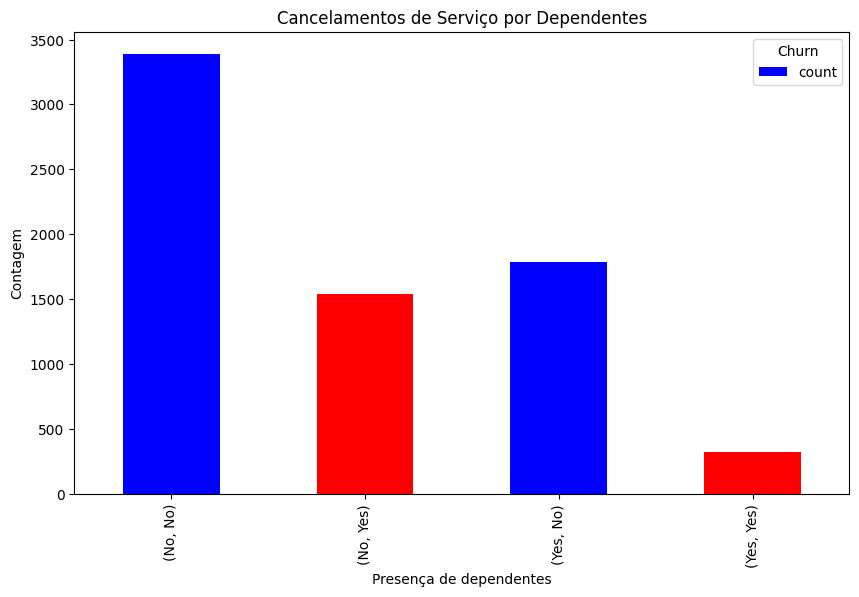

In [60]:
# Criar um gráfico de barras para visualizar os dados
churn_dependents.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))

# Adicionar títulos e rótulos aos eixos
plt.title('Cancelamentos de Serviço por Dependentes')
plt.xlabel('Presença de dependentes')
plt.ylabel('Contagem')
plt.legend(title='Churn')
plt.show()

Olhando para os números analisamos que a presença de dependentes tende a diminuir o percentual de churn

Sem dependentes = 31,28% de cancelamento

Com dependentes = 15,45% de cancelamento

Logo, pode-se concluir que a presença de dependentes afeta negativamente o número de cancelamentos.

#**Hipótese 3: Serviços Contratados**

---



Agora vou testar a quantidade de serviços contratados por quem realizou o cancelamento e por quem não realizou, minha hipótese é que o cancelamento seja maior entre clientes que não contrataram tantos serviços

In [61]:
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']
df['NumServices'] = df[services].apply(lambda x: x == 'Yes').sum(axis=1)

#Obter as médias de serviços contratos em cada grupo
churn_services = df[df['Churn'] == 'Yes']['NumServices'].mean()
non_churn_services = df[df['Churn'] == 'No']['NumServices'].mean()

print(f'Número médio de serviços - Churn: {churn_services:.2f}')
print(f'Número médio de serviços - Não Churn: {non_churn_services:.2f}')

Número médio de serviços - Churn: 2.51
Número médio de serviços - Não Churn: 2.70


In [62]:
#Analisar cada serviço separadamente
# Função para calcular e imprimir o percentual de cancelamento de um serviço
def calcular_percentual_cancelamento(servico):
    churn_counts = df[df[servico] == 'Yes']['Churn'].value_counts()
    total = churn_counts.sum()
    if 'Yes' in churn_counts:
        percentual = (churn_counts['Yes'] / total) * 100
    else:
        percentual = 0.0
    print('-------------'*20)
    print(f'Usuários de {servico.lower().replace("_", " ")}: {churn_counts}')
    print(f'Percentual de cancelamento de {servico.lower().replace("_", " ")}: {percentual:.2f}%\n')
    return percentual

# Telefone
percentual_phone = calcular_percentual_cancelamento('PhoneService')

# Segurança online
percentual_online_security = calcular_percentual_cancelamento('OnlineSecurity')

# Backup online
percentual_online_backup = calcular_percentual_cancelamento('OnlineBackup')

# Proteção de dispositivo
percentual_device_protection = calcular_percentual_cancelamento('DeviceProtection')

# TV streaming
percentual_streaming_tv = calcular_percentual_cancelamento('StreamingTV')

# Movies streaming
percentual_streaming_movies = calcular_percentual_cancelamento('StreamingMovies')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Usuários de phoneservice: Churn
No     4662
Yes    1699
Name: count, dtype: int64
Percentual de cancelamento de phoneservice: 26.71%

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Usuários de onlinesecurity: Churn
No     1724
Yes     295
Name: count, dtype: int64
Percentual de cancelamento de onlinesecurity: 14.61%

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

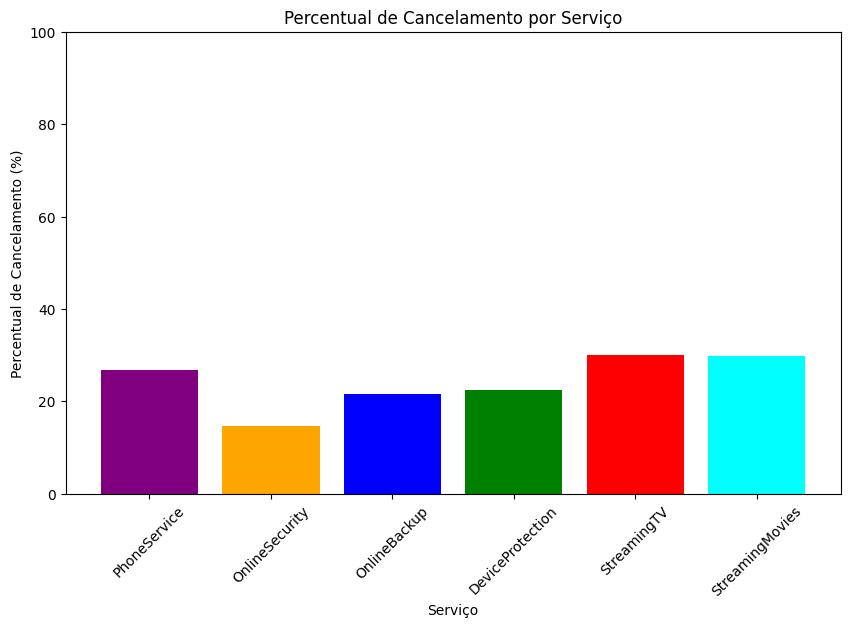

In [63]:
# Guardar os percentuais em uma lista
servicos = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']
percentuais = [
    percentual_phone,
    percentual_online_security,
    percentual_online_backup,
    percentual_device_protection,
    percentual_streaming_tv,
    percentual_streaming_movies
]

# Cores para o gráfico de barras
cores = ['purple', 'orange', 'blue', 'green', 'red', 'cyan']

# Criar um gráfico de barras com os percentuais de cancelamento
plt.figure(figsize=(10, 6))
plt.bar(servicos, percentuais, color=cores)
plt.title('Percentual de Cancelamento por Serviço')
plt.xlabel('Serviço')
plt.ylabel('Percentual de Cancelamento (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

Com base nessa análise temos uma classificação de quais serviços tem mais e quais tem menos churn

O maior percentual de cancelamentos está no streaming de TV, mostrano que esse é um serviço mais crítico com aproximadamente 30% de cancelamentos seguido por streaming de filmes (29,94%) e serviço de telefone (26,71%)

##Tipo de internet e relação com cancelamento

In [64]:
tipo_internet = df['InternetService'].value_counts()
print(tipo_internet)

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


In [65]:
#Relacionar o tipo de internet com o cancelamento e exibir os percentuais
churn_internet = df.groupby('InternetService')['Churn'].value_counts()
percentual_churn_internet = (churn_internet.groupby(level=0).apply(lambda x: x / x.sum() * 100)).round(2)
print(percentual_churn_internet)

InternetService  InternetService  Churn
DSL              DSL              No       81.04
                                  Yes      18.96
Fiber optic      Fiber optic      No       58.11
                                  Yes      41.89
No               No               No       92.60
                                  Yes       7.40
Name: count, dtype: float64


Entre os serviços de internet a fibra ótica tem o maior número de cancelamento, boa parte dos clientes desse serviço cancelou (41,89%)

#**Hipótese 3: Cancelamentos ocorrem com quem tem menos tempo de contrato**
-------------------------------

Agora vou analisar e quantidade de cancelasmento por tempo de contrato. Minha hipótese é que o percentual de churn diminua conforme o tempo de serviço aumenta

In [66]:
#Quantidade de clientes por tempo de contratação
contrato = df['Contract'].value_counts()
print(contrato)

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


In [67]:
#Cancelamentos e percentual em cada período de contrato
churn_por_periodo = df.groupby('Contract')['Churn'].value_counts().unstack().fillna(0)
percentual_churn_periodo = (churn_por_periodo.div(churn_por_periodo.sum(axis=1), axis=0) * 100).round(2)
print(percentual_churn_periodo)

Churn              No    Yes
Contract                    
Month-to-month  57.29  42.71
One year        88.73  11.27
Two year        97.17   2.83


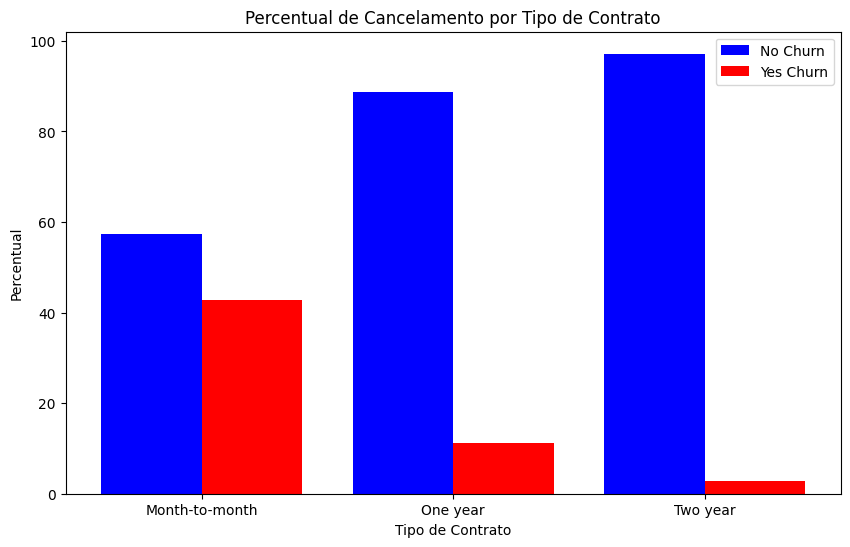

In [68]:
# Preparar dados para o gráfico
labels = churn_por_periodo.index.tolist()
no_churn = percentual_churn_periodo['No'].tolist()
yes_churn = percentual_churn_periodo['Yes'].tolist()

# Configurar o gráfico de barras
x = range(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, no_churn, width, label='No Churn', color='blue')
ax.bar([p + width for p in x], yes_churn, width, label='Yes Churn', color='red')

# Adicionar detalhes ao gráfico
ax.set_xlabel('Tipo de Contrato')
ax.set_ylabel('Percentual')
ax.set_title('Percentual de Cancelamento por Tipo de Contrato')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Olhando para essa análise podemos concluir que o percentual de churn diminui conforme o tempo de contrato aumenta.

#**Hipótese 4: Os clientes entram em contato com suporte técnico antes de cancelar**
--------------------------------

In [69]:
# Agrupar os dados por churn e suporte técnico
contato_com_suporte = df.groupby(['Churn', 'TechSupport']).size().unstack(fill_value=0)

# Calcular os percentuais
percentual_suporte = (contato_com_suporte.div(contato_com_suporte.sum(axis=1), axis=0) * 100).round(2)

# Exibir os dados
print('Contagem de contato com suporte técnico:')
print(contato_com_suporte)
print('\nPercentual de contato com suporte técnico:')
print(percentual_suporte)

Contagem de contato com suporte técnico:
TechSupport    No  No internet service   Yes
Churn                                       
No           2027                 1413  1734
Yes          1446                  113   310

Percentual de contato com suporte técnico:
TechSupport     No  No internet service    Yes
Churn                                         
No           39.18                27.31  33.51
Yes          77.37                 6.05  16.59


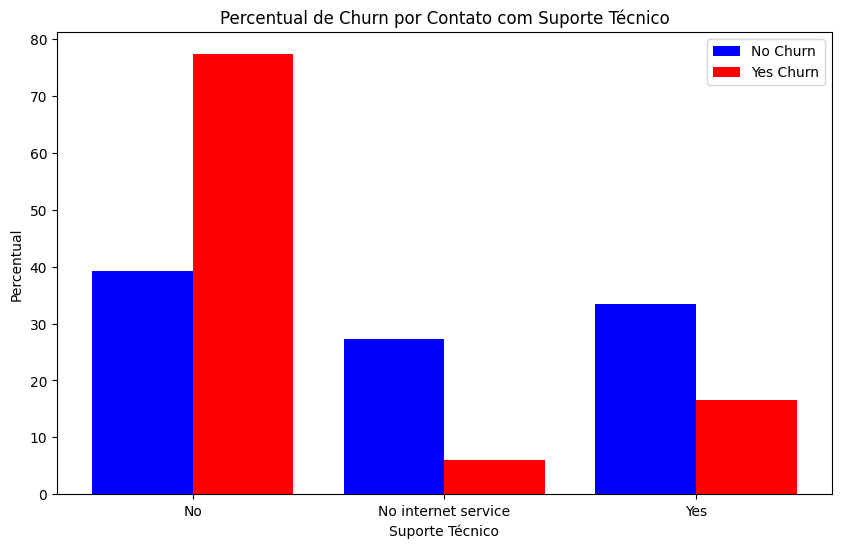

In [70]:
#Preparar dados para visualização
labels = contato_com_suporte.columns.tolist()
no_churn = percentual_suporte.loc['No'].tolist()
yes_churn = percentual_suporte.loc['Yes'].tolist()

# Configurar o gráfico de barras
x = range(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, no_churn, width, label='No Churn', color='blue')
ax.bar([p + width for p in x], yes_churn, width, label='Yes Churn', color='red')

# Adicionar detalhes ao gráfico
ax.set_xlabel('Suporte Técnico')
ax.set_ylabel('Percentual')
ax.set_title('Percentual de Churn por Contato com Suporte Técnico')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Como podemos ver o maior grupo de cancelamentos é entre clientes que não procuraram nenhum suporte técnico, o que anula a hipótese inicial.

#**Hipótese 5: avaliar as cobranças de quem cancelou e quem não cancelou**
-----------------------------

Aqui quero ver como é o comportamento de cobrança entre quem cancelou e quem não cancelou, minha hipótese é que quem cancelou esteja pagando mais do que o outro grupo

In [71]:
# Remover vírgulas e converter para inteiros
df['MonthlyCharges'] = df['MonthlyCharges'].str.replace(',', '').astype(int)

#Contar as cobranças de churn e não churn
cobranca_churn = df[df['Churn'] == 'Yes']['MonthlyCharges'].mean()
cobranca_nao_churn = df[df['Churn'] == 'No']['MonthlyCharges'].mean()

print(f'Cobrança média de churn: {cobranca_churn:.2f}')
print(f'Cobrança média de não churn: {cobranca_nao_churn:.2f}')

Cobrança média de churn: 4078.39
Cobrança média de não churn: 3314.81


Como a hipótese em média os clientes que cancelaram pagam mais do que quem não cancelou

#**Análise de Correlação**
---------------

In [72]:
# Converter a coluna Churn para valores numéricos
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Converter colunas categóricas em numéricas utilizando one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Calcular a correlação de todas as variáveis com Churn
correlation_with_churn = df_encoded.corr()['Churn'].sort_values(ascending=False)

# Exibir as correlações
print(correlation_with_churn)

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
PaperlessBilling_Yes                     0.191825
SeniorCitizen                            0.150889
MonthlyCharges                           0.092756
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService_Yes                         0.011942
gender_Male                             -0.008612
MultipleLines_No phone service          -0.011942
TotalCharges                            -0.040395
NumServices                             -0.052382
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner_Yes                             -0.150448
Dependents_Yes                          -0.164221


A análise de correlação confirmou alguns pontos tratados até aqui:

* InternetService_Fiber optic (0.308020): Clientes que usam fibra óptica
têm maior probabilidade de cancelamento.
* SeniorCitizen (0.150889): Clientes idosos têm maior probabilidade de cancelar.
* MonthlyCharges (0.092756): Maiores cobranças mensais estão ligeiramente associadas a uma maior probabilidade de cancelamento.
* Contract_Two year (-0.302253): Clientes com contrato de dois anos têm menor probabilidade de cancelar.
* TechSupport_Yes (-0.164674): Clientes com suporte técnico têm menor probabilidade de cancelar.
* Dependents_Yes (-0.164221): Clientes com dependentes têm menor probabilidade de cancelar.
* Partner_Yes (-0.150448): Clientes com parceiro têm menor probabilidade de cancelar.

Além disso, trouxe outros pontos que não foram tratados:

* PaymentMethod_Electronic check (0.301919): Clientes que pagam via cheque eletrônico têm maior probabilidade de cancelar.
* PaperlessBilling_Yes (0.191825): Clientes que optam pela fatura sem papel têm maior probabilidade de cancelar.


Olhando para essas novas descobertas temos mais 2 pontos de atenção, o método de recebimento da fatura e a forma de pagamento da mesma.

#**Conclusão**

Com essa análise de dados podemos afirmar algumas coisas sobre o perfil dos cancelamentos e ações que podem ser tomadas para evitar a quantidade de churn

* O percentual de cancelamento atual é de 26,54%, ou seja, atualmente temos uma situação  em que 1 a cada 4 clientes acabam cancelando o serviço.

* Em relação ao perfil dos clientes que cancelaram podemos afirmar que quem tem dependentes tende a ter uma menor taxa de cancelamentos. Também existe uma tendência maior de cancelamento entre os idosos.

* Em relação aos serviços as maiores taxas de cancelamentos estão nos serviços de:

-Streaming de TV (30,07% de cancelamentos)

-Streaming de filmes (29,94% de cancelamentos)

-Serviço de telefone (26,71% de cancelamentos)

Olhando para esses serviços específicos poderiamos realizar uma pesquisa com os clientes sobre a qualidade do catálogo dos streamings e buscar identificar quais conteúdos/ gêneros são mais assistidos e quais não são e assim focar nossas ações para conteúdos com mais acessos.

Já no serviço de telefonia podemos realizar uma pesquisa sobre as principais reclamações sobre o serviço e buscar formas de melhorar nosso atendimento.

Olhando para o serviço de internet vemos que em termos percentuais a fibra ótica tem uma quantidade maior de cancelamentos (41,89%) apesar de ser um serviço que tende a ser de melhor qualidade, isso aponta para uma insuficiencia na estrutura para atender todas as áreas de cobertura. O que podemos fazer é realizar um mapeamento dos serviços por área e levantar pontos críticos que precisam ter sua estrutura melhorada.

* Como era a hipótese, o número de cancelamentos diminui conforme o tempo de contrato aumenta.

O que poderiamos fazer é oferecer planos de fidelidade para aumentar o tempo que os clientes permanecem com o nosso serviço.

* Vemos também que a maior parte dos cancelamentos vêm de clientes que não entraram em contato com o suporte técnico, isso pode significar 2 coisas:

I) Os clientes precisam de suporte mas não tem acesso a ele, pode ser por desconhecerem os canais ou por congestionamento na central o que faz com que o cliente desista de esperar

II) Os problemas que levam ao cancelamento não são de natureza técnica

* A hipótese 5 foi confirmada, quem cancelou em média paga mais do que quem não cancelou

* A análise de correlação confirmou alguns pontos já tratados e trouxe outros dois problemas que são:
  
    -Pagamento via chegue via eletrônico: a solução aqui seria estimular os clientes a buscarem meios de pagamento melhores e/ou melhorar o sistema entorno dessa funcionalidade
    
    -Fatura sem papel: também está relacionado aos pagamentos, isso pode apontar para um problema entorno desses serviços o que torna ainda mais necessário a realização de correções de estrutura e de software nesse sentido